In [1]:
import torch
import csv
import numpy as np
import matplotlib.pyplot as plt
import os
import gc

from torch.utils.data import Dataset    
from torch.utils.data import DataLoader
import torch.nn as nn

from sklearn.cluster import AgglomerativeClustering
from sklearn.utils import class_weight
from sklearn import metrics

import sys
import numpy as np
np.set_printoptions(threshold=sys.maxsize)

DATASET = 'cryptobench'
DATA_PATH = f'/home/skrhakv/cryptic-nn/data/{DATASET}'
ESM_EMBEDDINGS_PATH = f'{DATA_PATH}/embeddings'
DISTANCE_MATRICES_PATH = f'{DATA_PATH}/distance-matrices'

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [2]:
from scipy.spatial import distance_matrix

def process_sequence_dataset(annotation_path, embeddings_path, distance_matrices_path, perform_assertions=True):
    Xs = {}
    Ys = {}

    with open(annotation_path) as f:
        reader = csv.reader(f, delimiter=";")
        for row in reader:
            id = row[0]
            if row[2] == 'UNKNOWN':
                id = row[0] + row[1]
                
            if perform_assertions:
                sequence = row[4]
            
            if id not in Xs:
                Xs[id] = []
                Ys[id] = []

            if row[3] == '':
                continue
            
            # load the precomputed embedding
            filename = id + '.npy'
            embedding = np.load(f'{embeddings_path}/{filename}')
            # load the distance matrix
            dist_matrix = np.load(f'{distance_matrices_path}/{id}.npy')
            if row[2] == 'UNKNOWN':
                dist_matrix = distance_matrix(dist_matrix, dist_matrix)

            # cluster 
            binding_residues_indices = [int(residue[1:]) for residue in row[3].split(' ')]
            binding_site_distance_matrix = dist_matrix[binding_residues_indices][:, binding_residues_indices]
            binding_site_embeddings = embedding[binding_residues_indices]

            # Median size of predicted binding sites is 6 (see src/E-regular-binding-site-predictor/evaluation/pocket-size.ipynb) for scPDB-enahnced model on LIGYSIS with ions.
            MEDIAN_POCKET_SIZE = 3

            # split the binding site into sub-pockets using hierarchical clustering
            clustering = AgglomerativeClustering(n_clusters=max(len(binding_residues_indices) // MEDIAN_POCKET_SIZE, 1))
            labels = clustering.fit_predict(binding_site_distance_matrix)

            # create positive training examples - all pairs of sub-pockets form positive examples
            for i in range(np.max(labels) + 1):
                embeddings_i = binding_site_embeddings[labels == i]
                mean_embedding_i = np.mean(embeddings_i, axis=0)

                for ii in range(np.max(labels) + 1):
                    if ii <= i:
                        continue
                    embeddings_ii = binding_site_embeddings[labels == ii]
                    mean_embedding_ii = np.mean(embeddings_ii, axis=0)

                    concatenated_embedding = np.concatenate((mean_embedding_i, mean_embedding_ii))
                    Xs[id].append(concatenated_embedding)
                    Ys[id].append(1) # positive example
                    concatenated_embedding = np.concatenate((mean_embedding_ii, mean_embedding_i))
                    Xs[id].append(concatenated_embedding)
                    Ys[id].append(1) # positive example


            # create negative training examples - pair the sub-pockets with random different residues that are distant (> 15A)
            # TODO: tune the distance threshold, currently it doesnt make sense to have it 0.0 as minimum, I just tried it for fun
            MIN_NON_BINDING_RESIDUES_DISTANCE_THRESHOLD = 0.0
            MAX_NON_BINDING_RESIDUES_DISTANCE_THRESHOLD = 15.0

            # get distance matrix for all residues to binding residues
            binding_site_distance_matrix = dist_matrix[binding_residues_indices]
            # for each sub-pocket, find negative residues and sample from them
            for i in range(np.max(labels) + 1):
                embeddings_i = binding_site_embeddings[labels == i]
                mean_embedding_i = np.mean(embeddings_i, axis=0)

                # find residues that are distant from all residues in the sub-pocket
                for j in range(dist_matrix.shape[0]):
                    if j in binding_residues_indices:
                        continue
                    distances_to_subpocket = binding_site_distance_matrix[:, j]
                    if np.all(distances_to_subpocket > MIN_NON_BINDING_RESIDUES_DISTANCE_THRESHOLD) and np.all(distances_to_subpocket < MAX_NON_BINDING_RESIDUES_DISTANCE_THRESHOLD):
                        negative_embedding = embedding[j]
                        concatenated_embedding = np.concatenate((mean_embedding_i, negative_embedding))
                        Xs[id].append(concatenated_embedding)
                        Ys[id].append(0) # negative example
                        concatenated_embedding = np.concatenate((negative_embedding, mean_embedding_i))
                        Xs[id].append(concatenated_embedding)
                        Ys[id].append(0) # negative example
    return Xs, Ys

class ClusteringClassifierDataset(Dataset):
    def __init__(self, _Xs, _Ys):
        _Xs_list = []
        _Ys_list = []

        for key, _ in _Xs.items():
            if len(_Xs[key]) == 0:
                continue
            # print(f'Processing {key} ...')
            _Xs_list.append(_Xs[key])
            _Ys_list.append(_Ys[key])
        del _Xs, _Ys
        gc.collect()
        
        print('Concatenating ...')
        Xs_list = np.concatenate(_Xs_list, axis=0)
        Ys_list = np.concatenate(_Ys_list, axis=0)

        print('Converting to torch tensor ...')
        self.Xs = torch.tensor(Xs_list, dtype=torch.float32)
        self.Ys = torch.tensor(Ys_list, dtype=torch.int64)

    def __len__(self):
        assert len(self.Xs) == len(self.Ys)
        return len(self.Xs)

    def __getitem__(self, idx):
        x = self.Xs[idx]
        y = self.Ys[idx]
        return x, y


In [3]:
DECISION_THRESHOLD = 0.5
DROPOUT = 0.3
LAYER_WIDTH = 256
ESM2_DIM  = 2560 * 2

class CryptoBenchClassifier(nn.Module):
    def __init__(self, dim=LAYER_WIDTH, dropout=DROPOUT):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=ESM2_DIM, out_features=dim)
        self.dropout1 = nn.Dropout(dropout)

        self.layer_2 = nn.Linear(in_features=dim, out_features=dim)
        self.dropout2 = nn.Dropout(dropout)

        self.layer_3 = nn.Linear(in_features=dim, out_features=1)

        self.relu = nn.ReLU()

    def forward(self, x):
      # Intersperse the ReLU activation function between layers
       return self.layer_3(self.dropout2(self.relu(self.layer_2(self.dropout1(self.relu(self.layer_1(x)))))))


def compute_class_weights(labels):
    class_weights=class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(labels), y=labels)
    class_weights=torch.tensor(class_weights,dtype=torch.float)
    return class_weights

def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

torch.manual_seed(42)

def train(model, optimizer, epochs, batch_size, train_dataset, test_dataset, validation=False, early_stopping_patience=None, print_stuff=True):
    model = model.to(device)

    # Create an optimizer
    _, y_train = train_dataset[:]
    X_test, y_test, = test_dataset[:]

    # compute class weights (because the dataset is heavily imbalanced)
    class_weights = compute_class_weights(y_train.numpy()).to(device)
    if print_stuff:
        print(f'Class weights: ', class_weights)
    # BCEWithLogitsLoss - sigmoid is already built-in!

    loss_fn = nn.BCEWithLogitsLoss(pos_weight=class_weights[1] / class_weights[0])
    # loss_fn = FocalLoss(alpha=1, gamma=2, bce_loss=loss_fn)

    X_test, y_test = X_test.to(device), y_test.to(device).float()

    train_losses, test_losses = [], []

    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    best_f1, best_mcc, best_acc, best_auprc, best_auc, best_epoch = 0, 0, 0, 0, 0, 0
    best_test_loss = float('inf')
    early_stopping_counter = 0
    for epoch in range(epochs):
        #
        # TEST
        #
        model.eval()
        with torch.inference_mode():

            test_logits = model(X_test).squeeze()
            
            test_loss = loss_fn(test_logits,
                                y_test)
            test_losses.append(test_loss.cpu().detach().numpy())

            test_pred = (torch.sigmoid(test_logits)>DECISION_THRESHOLD).float()

            # compute metrics on test dataset
            test_acc = accuracy_fn(y_true=y_test,
                                   y_pred=test_pred)
            
            fpr, tpr, thresholds = metrics.roc_curve(y_test.cpu().numpy(), torch.sigmoid(test_logits).cpu().numpy())
            roc_auc = metrics.auc(fpr, tpr)

            mcc = metrics.matthews_corrcoef(y_test.cpu().numpy(), test_pred.cpu().numpy())

            f1 = metrics.f1_score(y_test.cpu().numpy(), test_pred.cpu().numpy(), average='weighted')

            precision, recall, thresholds = metrics.precision_recall_curve(y_test.cpu().numpy(), torch.sigmoid(test_logits).cpu().numpy())
            auprc = metrics.auc(recall, precision)
            if auprc > best_auprc:
                best_test_loss = test_loss
                best_f1, best_mcc, best_acc, best_auprc, best_auc, best_epoch = f1, mcc, test_acc, auprc, roc_auc, epoch - 1
            elif early_stopping_patience is not None:
                early_stopping_counter += 1
                if early_stopping_counter >= early_stopping_patience:
                    break
        #
        # TRAIN
        #
        batch_losses = []
        for id_batch, (x_batch, y_batch) in enumerate(train_dataloader):

            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device).float()

            model.train()

            y_logits = model(x_batch).squeeze()
            y_pred = torch.round(torch.sigmoid(y_logits))

            loss = loss_fn(y_logits,
                           y_batch)
            acc = accuracy_fn(y_true=y_batch,
                              y_pred=y_pred)

            optimizer.zero_grad()

            loss.backward()

            optimizer.step()

            batch_losses.append(loss.cpu().detach().numpy())

        train_losses.append(sum(batch_losses) / len(batch_losses))
        #if epoch % 10 == 0:
        if print_stuff:
            print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {test_acc:.2f}% | Test loss: {test_loss:.5f}, AUC: {roc_auc:.4f}, MCC: {mcc:.4f}, F1: {f1:.4f}, AUPRC: {auprc:.4f}, sum: {sum(test_pred)}")

    if print_stuff:
        plt.plot(train_losses,label="train loss over epochs")
        plt.plot(test_losses,label="test loss over epochs")
        plt.legend()
        plt.show()

        plt.title('Receiver Operating Characteristic')
        plt.plot(fpr, tpr, 'r', label = 'AUC = %0.2f' % roc_auc)
        plt.legend(loc = 'lower right')
        plt.plot([0, 1], [0, 1],'r--')
        plt.xlim([0, 1])
        plt.ylim([0, 1])
        plt.ylabel('True Positive Rate')
        plt.xlabel('False Positive Rate')
        plt.show()
    
    import sys
    np.set_printoptions(threshold=sys.maxsize)
    torch.sigmoid(test_logits)
    
    if not validation:
        for i in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]:
            test_pred = (torch.sigmoid(test_logits)>i).float()
            # print(test_pred)
            test_acc = accuracy_fn(y_true=y_test,
                                    y_pred=test_pred)
            mcc = metrics.matthews_corrcoef(y_test.cpu().numpy(), test_pred.cpu().numpy())
            f1 = metrics.f1_score(y_test.cpu().numpy(), test_pred.cpu().numpy(), average='weighted')
            print(f'THRESHOLD: {i} | F1: {f1:.4f} | MCC: {mcc:.4f} | Test acc: {test_acc:.2f}%, sum: {sum(test_pred)}')
        return fpr, tpr, roc_auc
    else:
        return best_f1, best_mcc, best_acc, best_auprc, best_auc, best_epoch

Class weights:  tensor([1.6164, 0.7239], device='cuda:0')
Epoch: 0 | Loss: 0.32111, Accuracy: 30.09% | Test loss: 0.42496, AUC: 0.6027, MCC: 0.0147, F1: 0.1406, AUPRC: 0.7575, sum: 10.0
Epoch: 1 | Loss: 0.23239, Accuracy: 65.01% | Test loss: 0.38669, AUC: 0.7059, MCC: 0.2834, F1: 0.6640, AUPRC: 0.8110, sum: 4872.0
Epoch: 2 | Loss: 0.16453, Accuracy: 74.35% | Test loss: 0.33868, AUC: 0.8040, MCC: 0.4304, F1: 0.7499, AUPRC: 0.8959, sum: 5590.0
Epoch: 3 | Loss: 0.12031, Accuracy: 78.59% | Test loss: 0.32876, AUC: 0.8371, MCC: 0.4932, F1: 0.7865, AUPRC: 0.9152, sum: 6122.0
Epoch: 4 | Loss: 0.07075, Accuracy: 79.13% | Test loss: 0.37663, AUC: 0.8330, MCC: 0.4840, F1: 0.7861, AUPRC: 0.9098, sum: 6567.0
Epoch: 5 | Loss: 0.07896, Accuracy: 78.91% | Test loss: 0.38359, AUC: 0.8399, MCC: 0.4804, F1: 0.7845, AUPRC: 0.9157, sum: 6526.0
Epoch: 6 | Loss: 0.04627, Accuracy: 79.27% | Test loss: 0.46479, AUC: 0.8391, MCC: 0.4754, F1: 0.7820, AUPRC: 0.9138, sum: 6900.0
Epoch: 7 | Loss: 0.04102, Accuracy

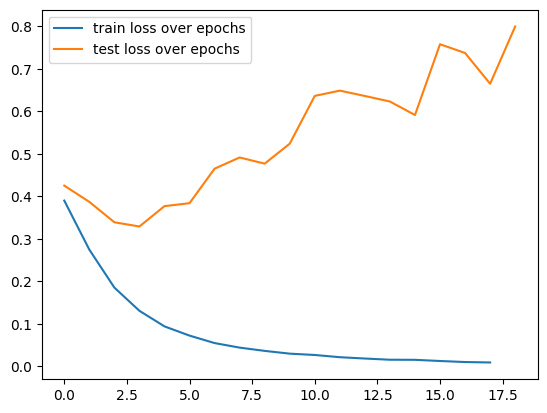

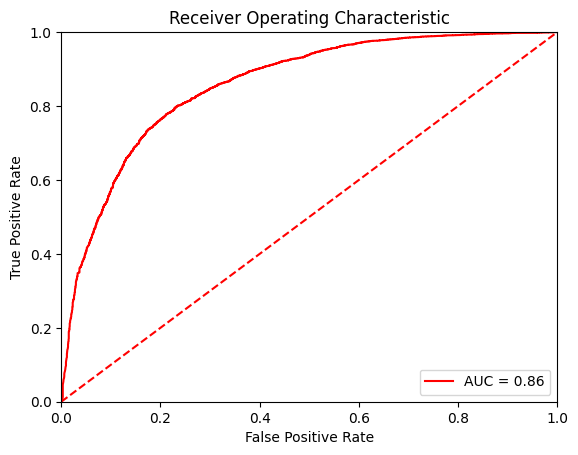

THRESHOLD: 0.1 | F1: 0.7297 | MCC: 0.4194 | Test acc: 77.45%, sum: 7997.0
THRESHOLD: 0.2 | F1: 0.7516 | MCC: 0.4551 | Test acc: 78.70%, sum: 7815.0
THRESHOLD: 0.3 | F1: 0.7668 | MCC: 0.4803 | Test acc: 79.60%, sum: 7673.0
THRESHOLD: 0.4 | F1: 0.7751 | MCC: 0.4901 | Test acc: 80.01%, sum: 7547.0
THRESHOLD: 0.5 | F1: 0.7829 | MCC: 0.5000 | Test acc: 80.40%, sum: 7415.0
THRESHOLD: 0.6 | F1: 0.7898 | MCC: 0.5087 | Test acc: 80.71%, sum: 7269.0
THRESHOLD: 0.7 | F1: 0.7933 | MCC: 0.5093 | Test acc: 80.69%, sum: 7095.0
THRESHOLD: 0.8 | F1: 0.8016 | MCC: 0.5242 | Test acc: 81.10%, sum: 6875.0
THRESHOLD: 0.9 | F1: 0.8070 | MCC: 0.5351 | Test acc: 81.13%, sum: 6542.0


In [ ]:
from scipy.cluster.hierarchy import ClusterWarning
from warnings import simplefilter
simplefilter("ignore", ClusterWarning)

Xs_train, Ys_train = process_sequence_dataset(f'/home/skrhakv/cryptoshow-analysis/data/F-clustering/train.txt', ESM_EMBEDDINGS_PATH, DISTANCE_MATRICES_PATH)
train_dataset = ClusteringClassifierDataset(Xs_train, Ys_train)

Xs_val, Ys_val = process_sequence_dataset(f'/home/skrhakv/cryptoshow-analysis/data/F-clustering/val.txt', ESM_EMBEDDINGS_PATH, DISTANCE_MATRICES_PATH)
val_dataset = ClusteringClassifierDataset(Xs_val, Ys_val)

dim=2048
dropout=0.5
lr=0.0001
EPOCHS = 20

model = CryptoBenchClassifier(dim=dim, dropout=dropout).to(device)
optimizer = torch.optim.AdamW(params=model.parameters(),
                            lr=lr)

fpr, tpr, roc_auc = train(model, optimizer, epochs=EPOCHS, batch_size=2048, 
      train_dataset=train_dataset, test_dataset=val_dataset, early_stopping_patience=10)


In [46]:
OUTPUT_PATH = '/home/skrhakv/cryptoshow-analysis/data/F-clustering/clustering.pt'
torch.save(model, OUTPUT_PATH)

# try on scPDB

In [4]:
from scipy.cluster.hierarchy import ClusterWarning
from warnings import simplefilter
simplefilter("ignore", ClusterWarning)

scPDB_DISTANCE_MATRICES_PATH = '/home/skrhakv/cryptoshow-analysis/data/E-regular-binding-site-predictor/enhanced-scPDB-coordinates'
scPDB_EMBEDDINGS_PATH = '/home/skrhakv/esm2/embeddings/enhanced-scPDB'

Xs_train, Ys_train = process_sequence_dataset(f'/home/skrhakv/cryptoshow-analysis/data/E-regular-binding-site-predictor/scPDB_enhanced_binding_sites_translated.csv', scPDB_EMBEDDINGS_PATH, scPDB_DISTANCE_MATRICES_PATH)
train_dataset = ClusteringClassifierDataset(Xs_train, Ys_train)

Xs_val, Ys_val = process_sequence_dataset(f'/home/skrhakv/cryptoshow-analysis/data/F-clustering/val.txt', ESM_EMBEDDINGS_PATH, DISTANCE_MATRICES_PATH)
val_dataset = ClusteringClassifierDataset(Xs_val, Ys_val)

dim=2048
dropout=0.5
lr=0.0001
EPOCHS = 20

model = CryptoBenchClassifier(dim=dim, dropout=dropout).to(device)
optimizer = torch.optim.AdamW(params=model.parameters(),
                            lr=lr)

fpr, tpr, roc_auc = train(model, optimizer, epochs=EPOCHS, batch_size=2048, 
      train_dataset=train_dataset, test_dataset=val_dataset, early_stopping_patience=10)

# TODO: Not finished, the kernel crashed (not sure why yet)

: 

: 

: 